The purpose of this notebook is to demonstrate how to refine with locally defined GSAS-II functions.



# Imports

In [90]:
# general libraties that exist on most systems

import os
import importlib
import sys
import time
import shutil
from IPython.display import clear_output

In [91]:
# The libraries that we will need in this notebook.
# If the required library doesn't exist, we install it via pip

required_packages   = {'numpy','xarray','ipympl','pymatgen','pybaselines','h5netcdf'}

for rp in required_packages:
    try:
        print('Checking %s package'%rp)
        globals()[rp] = importlib.import_module(rp)
    except:
        print('Installing %s'%rp)
        !! pip install $rp
        globals()[rp] = importlib.import_module(rp)
        if rp == 'pymatgen':
            !reset -f


import numpy as np
import xarray as xr

Checking pybaselines package
Checking numpy package
Checking xarray package
Checking h5netcdf package
Checking pymatgen package
Checking ipympl package


In [92]:
# Here we check if this notebook is running on Google Colab.
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [93]:
# If the notebbok is running on Google Colab, we mount google drive to instance
# and enable enable_custom_widget_manager for ipympl package to work properly.
# See See: https://matplotlib.org/ipympl/ for ipympl

if IN_COLAB:
    # mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # Enable enable_custom_widget_manager
    from google.colab import output
    output.enable_custom_widget_manager()

In [94]:
# importing matplotlib for plots.
%matplotlib widget
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.constrained_layout.use'] = True

# Setting up the example data path

# mxrd class

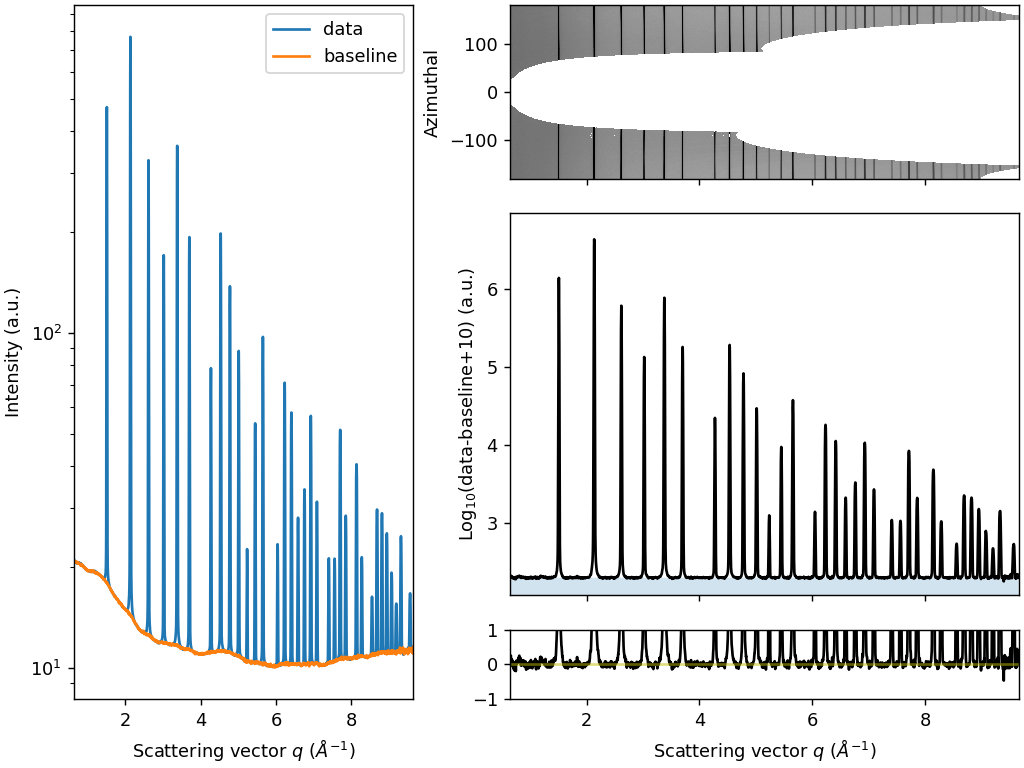

In [95]:
%run -i mxrd.py

here


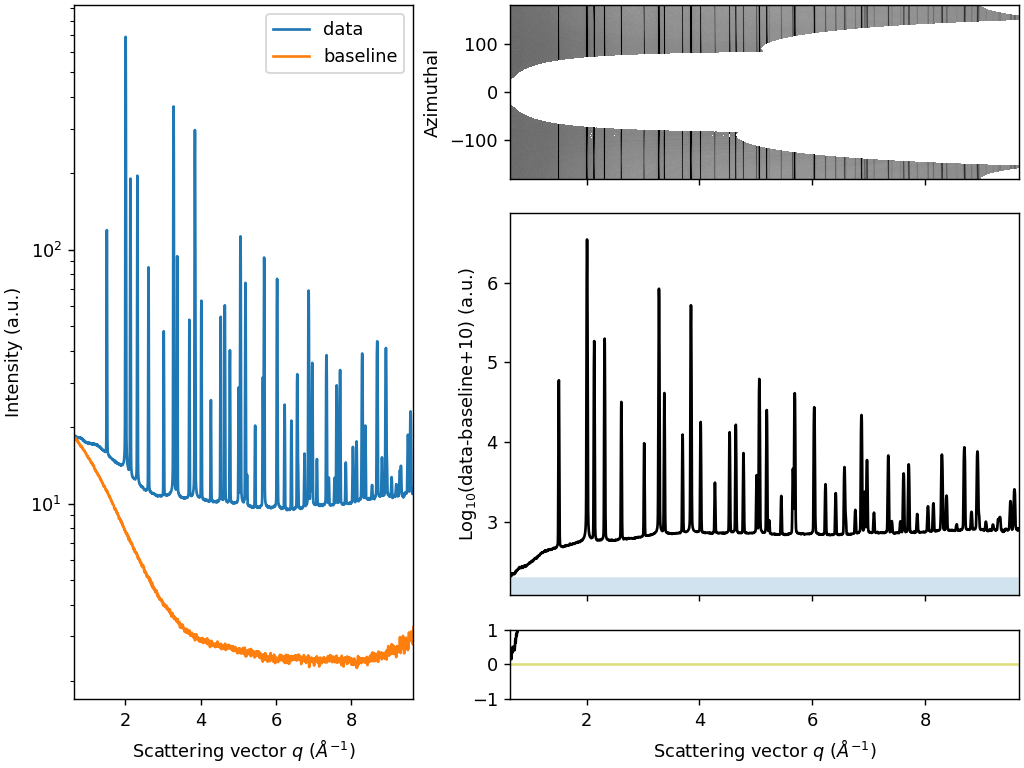

In [96]:
sample_Kapton = exrd()
# sample_Kapton.read_nc('integrated/Kapton.nc',plot=False)
sample_Kapton.read_data(nc_file='integrated/Kapton.nc',plot=False)
sample_Air = exrd()
sample_Air.read_data(nc_file='integrated/Air_scattering.nc',plot=False)


# sample_mix = exrd()
# sample_mix.read_nc('integrated/NIST-LaB6-CeO2-mix.nc',plot=False)
# sample_mix.get_baseline( i1d_bkg=sample_Kapton.ds.i1d,arpls_lam=1e5)


# sample_LaB6 = exrd()
# sample_LaB6.read_nc('integrated/NIST-LaB6-CeO2-mix.nc',plot=False)
# sample_LaB6.get_baseline( i1d_bkg=None,arpls_lam=1e5)


sample_LaB6 = exrd()
sample_LaB6.read_data(nc_file='integrated/NIST-LaB6-CeO2-mix.nc',plot=False)
sample_LaB6.get_baseline( i1d_bkg=sample_Air.ds.i1d,use_arpls=False)

In [97]:
phases = [
        {"mp_id":'none', "cif":'_cifs/LaB6.cif', "label":"LaB6", "scale":1, "scale_a":1, "scale_b":1, "scale_c":1},
        {"mp_id":'none', "cif":'_cifs/CeO2.cif', "label":"CeO2", "scale":1, "scale_a":1, "scale_b":1, "scale_c":1},
        # {"mp_id":'none', "cif":'_cifs/Zr.cif', "label":"Zr", "scale":1, "scale_a":1, "scale_b":1, "scale_c":1},
        ]

# phases = [
#         {"mp_id":'none', "cif":'_cifs/LaB6.cif', "label":"LaB6", "scale":1, "scale_a":1, "scale_b":1, "scale_c":1},
#         # {"mp_id":'mp-20194', "cif":'none', "label":"CeO2", "scale":1, "scale_a":1, "scale_b":1, "scale_c":1},
#         {"mp_id":'none', "cif":'_cifs/Zr.cif', "label":"Zr", "scale":1, "scale_a":1, "scale_b":1, "scale_c":1},
#         ]

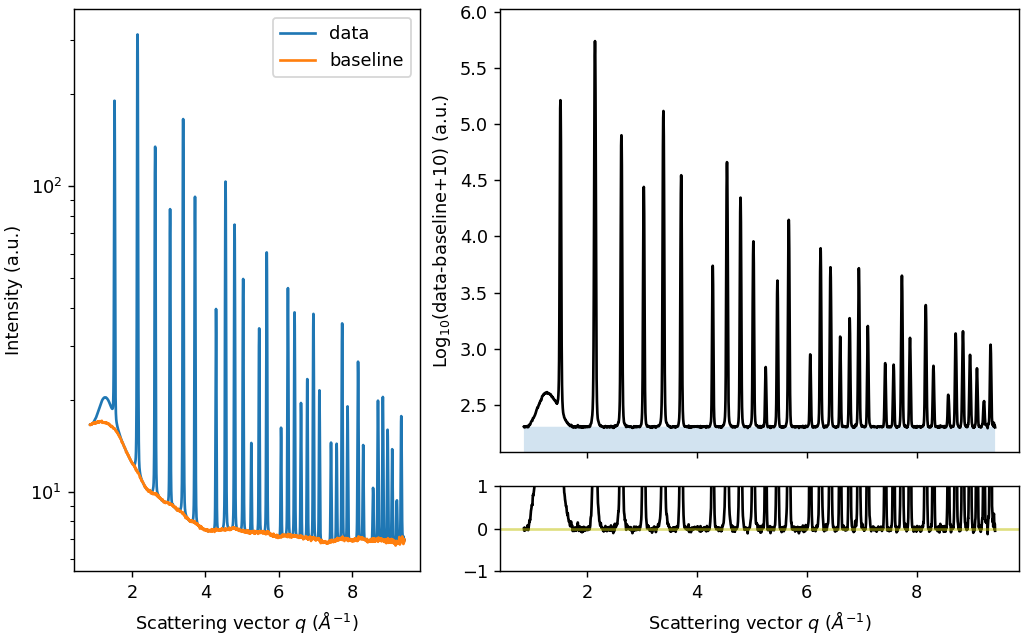

<xarray.Dataset> Size: 77kB
Dimensions:       (radial: 3844)
Coordinates:
  * radial        (radial) float64 31kB 0.851 0.8533 0.8555 ... 9.426 9.428 9.43
Data variables:
    i1d           (radial) float32 15kB 16.57 16.56 16.55 ... 6.927 6.899 6.931
    i1d_baseline  (radial) float64 31kB 16.56 16.57 16.59 ... 6.834 6.893 6.979

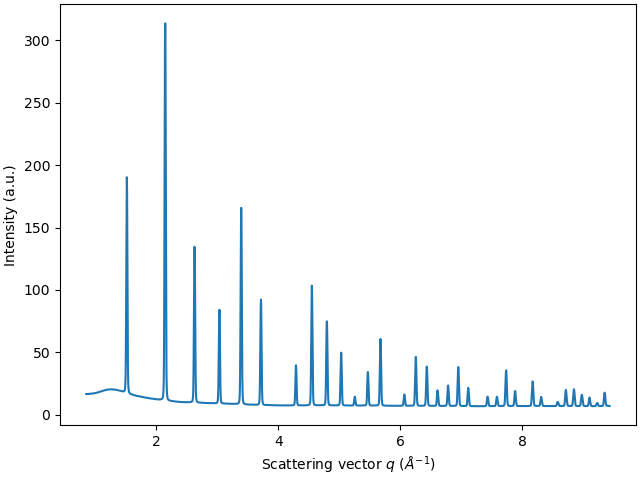

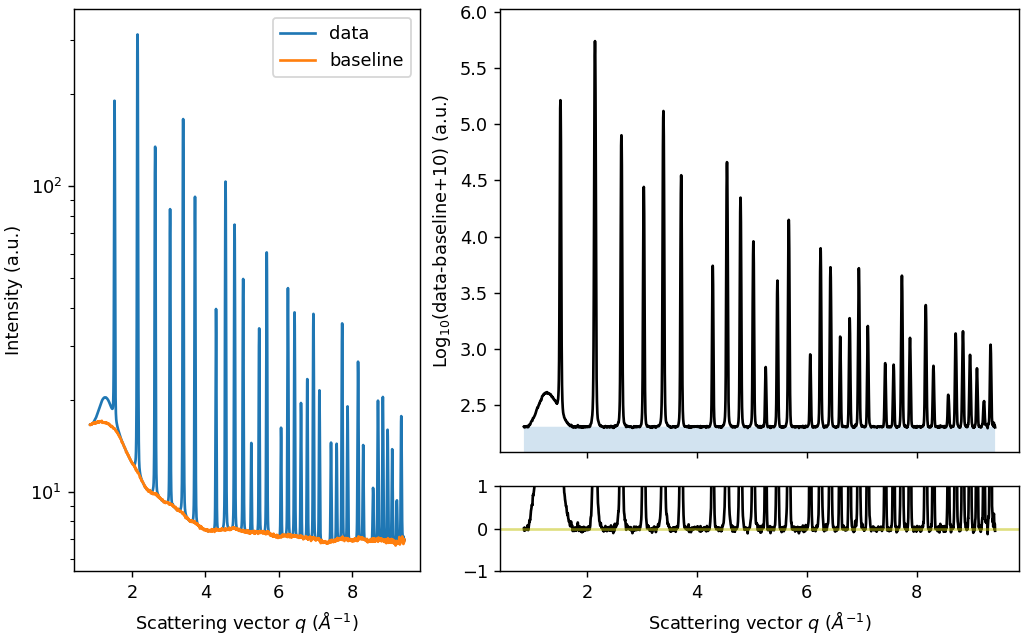

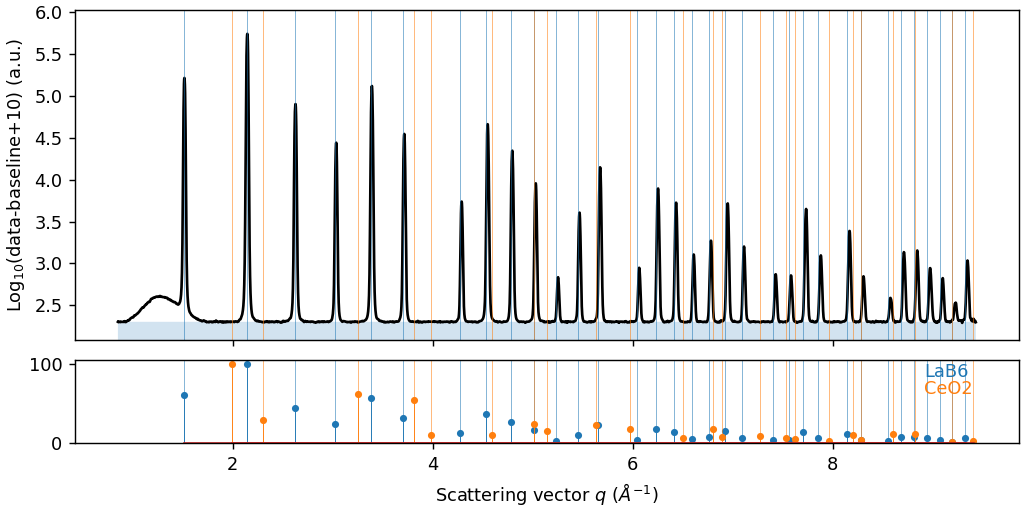

In [104]:
%run -i mxrd.py



plt.close('all')

sample_mix = exrd()
sample_mix.read_data(txt_file='integrated/NIST-LaB6.xy',plot=True,radial_range=(0.85,9.45))
sample_mix.get_baseline(i1d_bkg=sample_Air.ds.i1d,arpls_lam=1e5,plot=True,use_arpls=True)
sample_mix.load_phases(phases=phases)
# sample_mix.export_phases(phase_ind=None)

sample_mix.ds

In [105]:
np.log(np.e)

0.9999999999999999